# Project One Code 

## Econ 1680: MLTA and Econ

#### Name: Nadya Tan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Data Cleaning and Preparation

In [25]:
df_microdata = pd.read_csv('micro_world_139countries.csv', encoding='latin-1')

In [26]:
# select columns to keep 
selected = ['economycode', 'wgt','female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment', 'merchantpay_dig' ]
# new df 
df_selected = df_microdata[selected]

In [27]:
df_selected.shape

(143887, 32)

## One-hot Encoding 

In [28]:
# these variables need maps
# educ - change to 3 columns with 0-1 - if value is 4-5, put na in all 3 cols 
educ_dummies = pd.get_dummies(df_selected['educ'], prefix='educ').astype(int)
educ_dummies = educ_dummies.drop(columns=['educ_4', 'educ_5'])
# Fill NaN values for rows where educ was 4 or 5
educ_dummies.loc[df_selected['educ'].isin([4, 5]), :] = np.nan

# Convert inc_q to 5 columns
inc_q_dummies = pd.get_dummies(df_selected['inc_q'], prefix='inc_q').astype(int)
df_selected = pd.concat([df_selected, educ_dummies, inc_q_dummies], axis=1)

In [29]:
# Convert female to 0-1
df_selected['female'] = df_selected['female'].apply(lambda x: 1 if x == 1 else 0)

# Convert emp_in to 0-1
df_selected['emp_in'] = df_selected['emp_in'].apply(lambda x: 1 if x == 1 else 0)

# Convert urbanicity_f2f to 0-1
df_selected['urbanicity_f2f'] = df_selected['urbanicity_f2f'].apply(lambda x: 1 if x == 2 else 0)

In [30]:
# Convert these other financial variables to 0-1 and na for 3-4 
other_cols = [col for col in df_selected.columns if col in ['fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a','mobileowner', 'internetaccess']]
for col in other_cols:
    df_selected[col] = df_selected[col].apply(lambda x: 1 if x == 1 else (0 if x == 2 else None))

In [31]:
def scale_value(value):
    # did not perform the act
    if value == 4:
        return 0
    # performed using cash
    elif value == 2:
        return 1
    # performed using account 
    elif value == 1:
        return 2
    else:
        return np.nan 

# Create new columns with scaled values
df_selected['receive_wages_scaled'] = df_selected['receive_wages'].apply(scale_value)
df_selected['receive_transfers_scaled'] = df_selected['receive_transfers'].apply(scale_value)
df_selected['receive_pension_scaled'] = df_selected['receive_pension'].apply(scale_value)
df_selected['receive_agriculture_scaled'] = df_selected['receive_agriculture'].apply(scale_value)
df_selected['pay_utilities_scaled'] = df_selected['pay_utilities'].apply(scale_value)

# Replace old column with 0-1 
def replace_value(value):
    if value in [1, 2, 3]:
        return 1
    elif value == 4:
        return 0
    else:
        return np.nan  # NaN for values 5
columns_to_process = ['receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities']
for column in columns_to_process:
    df_selected[column] = df_selected[column].apply(replace_value)

In [32]:
def scale_value_remittances(value):
    # did not perform the act
    if value == 5:
        return 0
    # performed using cash or OTC
    elif value in [2, 3]:
        return 1
    # performed using account 
    elif value == 1:
        return 2
    else:
        return np.nan 
df_selected['remittances_scaled'] = df_selected['remittances'].apply(scale_value)

def replace_value_remittances(value):
    if value in [1, 2, 3, 4]:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df_selected['remittances'] = df_selected['remittances'].apply(replace_value)

In [33]:
# economycode 
economycode_dummies = pd.get_dummies(df_selected['economycode']).astype(int)
df_selected = pd.concat([df_selected, economycode_dummies], axis=1)

In [34]:
df_selected.shape

(143887, 185)

In [35]:
df_selected.to_csv('microdata_cleaned.csv')

## Summary Statistics 

In [36]:
df_selected[['female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment']].describe()

,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment
count,143887.000000,143420.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,82706.000000,143887.000000,143887.000000,143114.000000,143067.000000,143298.000000,113897.000000,143145.000000,45438.000000,143750.000000,143296.000000,143887.000000
mean,0.532258,41.056889,1.968204,3.234239,0.643971,0.304843,0.708646,0.656001,0.260259,0.540563,0.525565,0.384421,0.193665,0.121097,0.134376,0.579545,0.917140,0.881357,0.704625,0.648856
std,0.498960,17.342777,0.723923,1.419803,0.478826,0.460343,0.454388,0.475042,0.438779,0.498354,0.499348,0.486460,0.395170,0.326241,0.341057,0.493634,0.275674,0.323370,0.456213,0.477329
min,0.000000,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,38.000000,2.000000,3.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,54.000000,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,99.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
df_selected[['merchantpay_dig','receive_wages_scaled', 'receive_transfers_scaled','receive_pension_scaled','receive_agriculture_scaled','pay_utilities_scaled', 'remittances_scaled' ]].describe()

,merchantpay_dig,receive_wages_scaled,receive_transfers_scaled,receive_pension_scaled,receive_agriculture_scaled,pay_utilities_scaled,remittances_scaled
count,114281.000000,140726.000000,138840.000000,140944.000000,112613.000000,136885.000000,37588.000000
mean,0.325032,0.669954,0.316069,0.200420,0.155710,0.902509,1.634671
std,0.468389,0.901710,0.714199,0.590134,0.440312,0.878850,0.657423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [38]:
df_selected[['fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a']].describe()

,fin2,fin4,fin5,fin6,fin7,fin8,fin9,fin10,fin13a
count,142816.000000,72811.000000,88782.000000,88807.000000,88619.000000,32569.000000,88556.000000,88534.000000,17634.000000
mean,0.510762,0.744214,0.585231,0.645636,0.368251,0.830391,0.786463,0.801760,0.741692
std,0.499886,0.436305,0.492685,0.478323,0.482333,0.375295,0.409806,0.398676,0.437717
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# educ, economycode and income one hot encodes 
df_selected[['educ_1', 'educ_2', 'educ_3', 'inc_q_1', 'inc_q_2', 'inc_q_3', 'inc_q_4', 'inc_q_5']].describe()

,educ_1,educ_2,educ_3,inc_q_1,inc_q_2,inc_q_3,inc_q_4,inc_q_5
count,143132.000000,143132.000000,143132.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000
mean,0.269597,0.505834,0.224569,0.162301,0.172913,0.191442,0.214933,0.258411
std,0.443752,0.499968,0.417300,0.368728,0.378174,0.393437,0.410777,0.437763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
percentage_breakdown = df_selected['economycode'].value_counts(normalize=True) * 100
print(percentage_breakdown.to_markdown())

| economycode   |   proportion |
|:--------------|-------------:|
| CHN           |     2.43246  |
| IND           |     2.08497  |
| RUS           |     1.39762  |
| IDN           |     0.738079 |
| LSO           |     0.712365 |
| LBN           |     0.71028  |
| GAB           |     0.70889  |
| CYP           |     0.708195 |
| SAU           |     0.708195 |
| THA           |     0.706805 |
| ZAF           |     0.70472  |
| BEL           |     0.70333  |
| IRQ           |     0.70333  |
| KOR           |     0.702635 |
| JPN           |     0.70194  |
| LTU           |     0.701245 |
| JOR           |     0.701245 |
| AZE           |     0.70055  |
| USA           |     0.699855 |
| CAN           |     0.699855 |
| NIC           |     0.699855 |
| SWE           |     0.69916  |
| LVA           |     0.69916  |
| SVK           |     0.698465 |
| CZE           |     0.698465 |
| LKA           |     0.698465 |
| IRN           |     0.698465 |
| BGR           |     0.698465 |
| HUN     

# Comparing Initial Regressions 


In [33]:
# start with a theory --> hypothesis of what could be causing it + limit the number of variables (start w 10 variables - already a lot!) 

# be mindful of which columns I am dropping Nas with respect to 

chosen_variables = ['age', 'female', 'educ_1', 'educ_2', 'educ_3', 'inc_q_1', 'inc_q_2', 'inc_q_3', 'inc_q_4', 'account_fin', 'account_mob', 'receive_wages', 'anydigpayment', 'fin4', 'fin8', 'fin13a', 'wgt']

In [19]:
df = pd.read_csv("microdata_cleaned.csv", index_col=0)

In [34]:
df_selected = df[chosen_variables].copy()

In [35]:
df_selected.dropna(inplace=True)

In [36]:
df_selected.shape

(2404, 17)

In [37]:
y=df_selected['fin13a']
X=df_selected.drop(columns=['fin13a', 'wgt', 'educ_1', 'inc_q_1'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1680,stratify=y)

In [38]:
weights_train = df_selected.loc[X_train.index, 'wgt']

#### OLS Regression

In [39]:
# use weights for this! 
ols_result = sm.OLS(y_train, X_train, weights=weights_train).fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 fin13a   R-squared:                      -0.322
Model:                            OLS   Adj. R-squared:                 -0.328
Method:                 Least Squares   F-statistic:                    -52.37
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               1.00
Time:                        17:28:52   Log-Likelihood:                -1052.6
No. Observations:                2163   AIC:                             2127.
Df Residuals:                    2152   BIC:                             2190.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
age              -0.0015      0.001     -2.130

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\statsmodels\regression\linear_model.py:921: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


#### LASSO regression 

In [44]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=100)

# Construct vectors to store mean prediction errors and coefficients
cv_errs = []
coefs = []
MSE = float('inf')
best_lasso_alpha = 0

# Loop for running Lasso regression for different values of alpha
for a in alphas:
    # Define pipeline object
    lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=a))
    
    # Run Lasso regression
    lassoReg.fit(X_train, y_train, lasso__sample_weight=weights_train)
    
    # Obtain predicted values of output
    y_pred = lassoReg.predict(X_test)
    
    # Compute mean squared error
    cv_errs.append(mean_squared_error(y_test, y_pred))
    
    # Store coefficients
    coefs.append(lassoReg['lasso'].coef_)
    
    # Store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE:
        MSE = mean_squared_error(y_test, y_pred)
        best_lasso_alpha = a

print("Best Lasso Alpha:", best_lasso_alpha)

Best Lasso Alpha: 1e-06


Text(0, 0.5, 'Mean Squared Error')

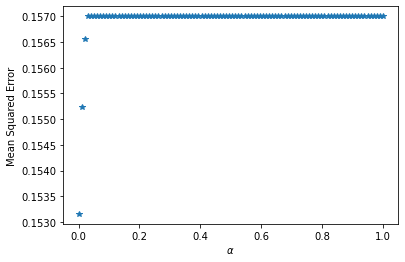

In [45]:
# Plot the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#### Ridge Regression - searching for optimal alpha 

In [46]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=100)

# Construct vectors to store mean prediction errors and coefficients
cv_errs = []
coefs = []
MSE = 10
best_ridge_alpha = 0

# Loop for running ridge regression for different values of alpha
for a in alphas:
    
    # define pipeline object
    ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= a * X_train.shape[0]))
    # run Ridge regression
    ridgeReg.fit(X_train, y_train, ridge__sample_weight=weights_train)
    # obtain predicted values of output
    y_pred = ridgeReg.predict(X_test)
    # compute mean squared error
    cv_errs.append(mean_squared_error(y_test, y_pred))
    # store coefficients
    coefs.append(ridgeReg['ridge'].coef_)
    
    # store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE: #np.mean((y_pred - y_test)**2)
        MSE = mean_squared_error(y_test, y_pred)
        best_ridge_alpha = a
        
print(best_ridge_alpha)
    
# Create dataframe for storing coefficients
coefs = pd.DataFrame(coefs, columns=X.columns)
coefs.set_index(alphas, inplace=True)

1e-06


Text(0, 0.5, 'Mean Squared Error')

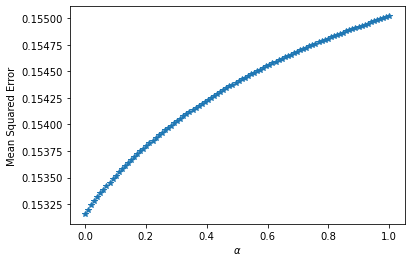

In [47]:
# Plot the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#### Comparing Regression Outputs


In [49]:
alpha = best_lasso_alpha
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha= alpha * np.sqrt(X_train.shape[0])))
lassoReg.fit(X_train, y_train)

alpha = best_ridge_alpha
ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= alpha * np.sqrt(X_train.shape[0])))
ridgeReg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('ridge', Ridge(alpha=4.650806381693394e-05))])

In [50]:
coef_comp=pd.DataFrame({'var':X.columns, 'val_ols':ols_result.params.tolist(), 'val_lasso':lassoReg[-1].coef_, 'var_ridge':ridgeReg[-1].coef_})

In [51]:
print(coef_comp.to_markdown())


|    | var           |     val_ols |   val_lasso |   var_ridge |
|---:|:--------------|------------:|------------:|------------:|
|  0 | age           | -0.00150999 | -0.0182504  | -0.0183034  |
|  1 | female        | -0.0250663  | -0.012319   | -0.0123727  |
|  2 | educ_2        | -0.0159708  | -0.00758588 | -0.00798536 |
|  3 | educ_3        | -0.0283365  | -0.0136129  | -0.0140359  |
|  4 | inc_q_2       | -0.0768572  | -0.0201366  | -0.0202306  |
|  5 | inc_q_3       | -0.0229746  | -0.00741255 | -0.00749605 |
|  6 | inc_q_4       | -0.0215269  | -0.00896973 | -0.00904967 |
|  7 | account_fin   |  0.29738    |  0          |  0          |
|  8 | account_mob   |  0.29738    |  0          |  0          |
|  9 | receive_wages |  0.0291207  |  0.0135952  |  0.0136496  |
| 10 | anydigpayment |  0.29738    |  0          |  0          |
| 11 | fin4          |  0.0196846  |  0.00739545 |  0.00745977 |
| 12 | fin8          | -0.0254041  | -0.00891175 | -0.00896094 |


In [52]:
print(coef_comp.to_latex())

\begin{tabular}{llrrr}
\toprule
 & var & val_ols & val_lasso & var_ridge \\
\midrule
0 & age & -0.001510 & -0.018250 & -0.018303 \\
1 & female & -0.025066 & -0.012319 & -0.012373 \\
2 & educ_2 & -0.015971 & -0.007586 & -0.007985 \\
3 & educ_3 & -0.028337 & -0.013613 & -0.014036 \\
4 & inc_q_2 & -0.076857 & -0.020137 & -0.020231 \\
5 & inc_q_3 & -0.022975 & -0.007413 & -0.007496 \\
6 & inc_q_4 & -0.021527 & -0.008970 & -0.009050 \\
7 & account_fin & 0.297380 & 0.000000 & 0.000000 \\
8 & account_mob & 0.297380 & 0.000000 & 0.000000 \\
9 & receive_wages & 0.029121 & 0.013595 & 0.013650 \\
10 & anydigpayment & 0.297380 & 0.000000 & 0.000000 \\
11 & fin4 & 0.019685 & 0.007395 & 0.007460 \\
12 & fin8 & -0.025404 & -0.008912 & -0.008961 \\
\bottomrule
\end{tabular}



In [24]:
X_test_with_const = sm.add_constant(X_test_new)  # Add constant to X_test
y_pred = ols_result_new.predict(X_test_with_const)

# Comparing predictions with actual values (y_test)
from sklearn.metrics import mean_squared_error, r2_score

# Calculating Mean Squared Error
mse = mean_squared_error(y_test_new, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.1741697779461992


In [36]:
X_test_with_const = sm.add_constant(X_test)  # Add constant to X_test
y_pred = ols_result.predict(X_test_with_const)

# Comparing predictions with actual values (y_test)
from sklearn.metrics import mean_squared_error, r2_score

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.12873358253183415


In [25]:
# Predicting values using Lasso on X_test
y_pred_lasso = lassoReg.predict(X_test_new)

# Evaluating Lasso performance
mse_lasso = mean_squared_error(y_test_new, y_pred_lasso)
r2_lasso = r2_score(y_test_new, y_pred_lasso)
print("Lasso Regression:")
print("Mean Squared Error:", mse_lasso)
print("R-squared:", r2_lasso)

# Predicting values using Ridge on X_test
y_pred_ridge = ridgeReg.predict(X_test_new)

# Evaluating Ridge performance
mse_ridge = mean_squared_error(y_test_new, y_pred_ridge)
r2_ridge = r2_score(y_test_new, y_pred_ridge)
print("\nRidge Regression:")
print("Mean Squared Error:", mse_ridge)
print("R-squared:", r2_ridge)

Lasso Regression:
Mean Squared Error: 0.24230785600035074
R-squared: -1.0446675312136833e-05

Ridge Regression:
Mean Squared Error: 0.17409432828079507
R-squared: 0.28150845019459736


In [45]:
# Predicting values using Lasso on X_test
y_pred_lasso = lassoReg.predict(X_test)

# Evaluating Lasso performance
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression:")
print("Mean Squared Error:", mse_lasso)
print("R-squared:", r2_lasso)

# Predicting values using Ridge on X_test
y_pred_ridge = ridgeReg.predict(X_test)

# Evaluating Ridge performance
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("\nRidge Regression:")
print("Mean Squared Error:", mse_ridge)
print("R-squared:", r2_ridge)

Lasso Regression:
Mean Squared Error: 0.14027777777777778
R-squared: -3.094155140925814e-05

Ridge Regression:
Mean Squared Error: 0.12840942532057098
R-squared: 0.08457775321453165
